## OPT : Get pubmed search results counts for terms +- subtype/pleitropy
* note - slow, urls

Base on (?):
```
Since there is no gold standard to evaluate such novel predictions for indication expansion or drug repurposing potential, we utilized the scientific literature as an external source of validation by retrieving suggested drug targets from published articles and checking what proportion of these were predicted with our model. Specifically, we searched for literature hits of a gene or protein being mentioned as a (potential) therapeutic target in titles and abstracts on MEDLINE. 
We found a large number of text mining instances corresponding to 6,696 unique diseases that co-occurred with the 2,858 druggable genomes. There were 1,247 in common diseases between the predicted set and text mining hits, representing a highly significant proportion as assessed by hypergeometric test (p = 6.33e-113) (Fig. 4d; Additional file 7: Table 3). 
```


* For the 150 + 150 predicted novel/misannotated candidates (i.e cases where predictions differ from the annotations), the p-value is not significant (`Ttest_indResult(statistic=1.084, pvalue=0.139`)
    * This is unlike the models top ranked predictions

In [34]:
import pandas as pd
from Bio import Entrez
from time import sleep
from scipy.stats import ttest_rel, chi2, ttest_ind

In [19]:
input_preds_file = "./outputs/S1-candidate_errors.csv"## orig was df_res in munge_pt2_disease_hierarchy.ipynb. # here, run on candidates instead



Entrez.email = "dan.ofer@mail.huji.ac.il"

In [20]:
df_res = pd.read_csv(input_preds_file).rename(columns={"CV_mean":"pred_1"},errors="ignore")
df_res = df_res.filter(["name","pred_1","has_children","CV_pred"],axis=1).drop_duplicates()
df_res

,name,pred_1,has_children,CV_pred
0,phosphorus metabolism disease,0.97,0,1
1,benign prostatic hyperplasia,0.97,0,1
2,zika virus congenital syndrome,0.95,0,1
3,malignant childhood germ cell neoplasm,0.95,0,1
4,benign neoplasm of stomach,0.95,0,1
...,...,...,...,...
1940,7q11.23 microduplication syndrome,0.04,1,0
1941,trichorhinophalangeal syndrome type i or iii,0.04,1,0
1942,x-linked intellectual disability - hypogammagl...,0.04,1,0
1943,spastic paraplegia-optic atrophy-neuropathy sy...,0.03,1,0


In [21]:
df_res.select_dtypes(["number"]).agg(["mean","sum","size"]).round(2)

,pred_1,has_children,CV_pred
mean,0.43,0.62,0.38
sum,838.29,1204.00,741.00
size,1945.00,1945.00,1945.00


In [22]:
df_res.sort_values(["pred_1"],ascending=False,inplace=True)
df_sample = pd.concat([df_res.head(150),df_res.tail(150)],ignore_index=True) # was 100
df_sample

,name,pred_1,has_children,CV_pred
0,phosphorus metabolism disease,0.97,0,1
1,benign prostatic hyperplasia,0.97,0,1
2,zika virus congenital syndrome,0.95,0,1
3,malignant childhood germ cell neoplasm,0.95,0,1
4,benign neoplasm of stomach,0.95,0,1
...,...,...,...,...
295,7q11.23 microduplication syndrome,0.04,1,0
296,trichorhinophalangeal syndrome type i or iii,0.04,1,0
297,x-linked intellectual disability - hypogammagl...,0.04,1,0
298,spastic paraplegia-optic atrophy-neuropathy sy...,0.03,1,0


In [23]:
%%time
from Bio import Entrez
from time import sleep
from scipy.stats import ttest_rel, chisquare

## https://biopython.org/docs/1.76/api/Bio.Entrez.html

#     Entrez.email = ""
pubmed_count_1 = []
pubmed_count_2 = []
## add total res in search? 
for i,n in enumerate(list(df_sample["name"])):
    if i%%10 ==0:
        print(i)
    # handle = Entrez.egquery(term="genetic eye tumor")
    ##OLD, orig: f"{n} AND ((subtype) OR (pleiotropy))"
    ## oops, should be "AND" no t not. I will flip
    handle_1 = Entrez.egquery(term = f"((({n}) NOT (subtype)) NOT (pleiotropy)) NOT (submanifest)")
    ##OLD, orig handle 2: was "not "x . Now it is total X. 
#         handle_2 = Entrez.egquery(term = f"{n} NOT ((subtype) OR (pleiotropy))")
    handle_2 = Entrez.egquery(term = f"{n}")

    record_1 = Entrez.read(handle_1)
    record_2 = Entrez.read(handle_2)

    for row in record_1["eGQueryResult"]:
        if row["DbName"] == "pubmed":
            pubmed_count_1.append(row["Count"])
    for row in record_2["eGQueryResult"]:
        if row["DbName"] == "pubmed":
            pubmed_count_2.append(row["Count"])
    sleep(0.02)
pubmed_count_1 = pd.to_numeric(pubmed_count_1)
pubmed_count_2 = pd.to_numeric(pubmed_count_2)
## add total? 

phosphorus metabolism disease
benign prostatic hyperplasia
zika virus congenital syndrome
malignant childhood germ cell neoplasm
benign neoplasm of stomach
sexual and gender identity disorders
genetic eye tumor
ewing sarcoma
metastatic malignant neoplasm in the colon
benign neoplasm of ear
conjunctival intraepithelial neoplasm
abnormality of the thyroid gland
covid-19
acquired mineral metabolism disease
benign neoplasm of tongue
glottis carcinoma
major depressive disorder
smallpox
lesion of sciatic nerve
histiocytic sarcoma
endocervical carcinoma
anaplastic oligodendroglioma
autism
alexithymia
female breast carcinoma
laryngeal squamous cell carcinoma
carcinoma of supraglottis
benign neoplasm of lip
papillary serous cystadenocarcinoma
glomus tumor
digestive duplication
paranoid personality disorder
chagas disease
enthesitis
sarcomatoid squamous cell carcinoma
cancer-associated retinopathy
atp biosynthetic process
esophageal small cell neuroendocrine carcinoma
acquired factor vii deficie

cyanosis, transient neonatal
cataract 16 multiple types
spinocerebellar ataxia type 42
isolated congenital anonychia
isolated growth hormone deficiency type iii
neurodevelopmental disorder-craniofacial dysmorphism-cardiac defect-hip dysplasia syndrome
duane-radial ray syndrome
lamb2-related infantile-onset nephrotic syndrome
chromosome 17p13.1 deletion syndrome
renpenning syndrome
microcephalic primordial dwarfism due to rttn deficiency
microspherophakia and/or megalocornea, with ectopia lentis and with or without secondary glaucoma
atypical progressive supranuclear palsy
syndactyly type 2
becker nevus syndrome
cerebral amyloid angiopathy, app-related
acheiropodia
autosomal dominant cerebellar ataxia type 1
chromosome 9p deletion syndrome
spondyloepiphyseal dysplasia and spondyloepimetaphyseal dysplasia
antidepressant-induced side effect
chromosome 22q11.2 microduplication syndrome
marcus-gunn syndrome
oculoauriculovertebral spectrum with radial defects
bazex-dupré-christol syndrome
be

In [24]:
df_groups = pd.DataFrame({"results count - subtype AND res":pubmed_count_2-pubmed_count_1,
                          "total":pubmed_count_2},index=df_sample["name"])
# df_groups["total"] = pubmed_count_1+pubmed_count_2 # ORIG/old
# df_groups["total"] = pubmed_count_2

mid = df_groups.shape[0]//2
df_groups["group"] = 1
df_groups["group"].iloc[mid:] = 0

df_groups["freq_subtype"] = df_groups["results count - subtype AND res"].div(df_groups["total"])
# df_groups["freq_no_subtype"] = pubmed_count_2/df_groups["total"]
df_groups

,results count - subtype AND res,total,group,freq_subtype
name,,,,
phosphorus metabolism disease,10,6961,1,0.001437
benign prostatic hyperplasia,241,30668,1,0.007858
zika virus congenital syndrome,1,1040,1,0.000962
malignant childhood germ cell neoplasm,47,1940,1,0.024227
benign neoplasm of stomach,1209,133465,1,0.009059
...,...,...,...,...
7q11.23 microduplication syndrome,0,34,0,0.000000
trichorhinophalangeal syndrome type i or iii,6702,769573,0,0.008709
x-linked intellectual disability - hypogammaglobulinemia - progressive neurological deterioration,0,1,0,0.000000


In [44]:
df_groups.describe()

,results count - subtype AND res,total,group,freq_subtype
count,300.000000,3.000000e+02,300.000000,292.000000
mean,422.443333,4.121771e+04,0.500000,0.010281
std,2820.853294,2.418243e+05,0.500835,0.018573
min,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,5.900000e+01,0.000000,0.000000
50%,6.000000,7.655000e+02,0.500000,0.004617
75%,44.000000,6.966750e+03,1.000000,0.010806
max,44560.000000,3.787242e+06,1.000000,0.177885


In [25]:
# df_groups.to_csv("300_esearch_res.csv")

In [27]:
df_groups.to_csv("./"+input_preds_file.strip(".csv")+"_300_esearch_res.csv")

In [35]:
print(df_groups.reset_index(drop=True))

     results count - subtype AND res   total  group  freq_subtype
0                                 10    6961      1      0.001437
1                                241   30668      1      0.007858
2                                  1    1040      1      0.000962
3                                 47    1940      1      0.024227
4                               1209  133465      1      0.009059
..                               ...     ...    ...           ...
295                                0      34      0      0.000000
296                             6702  769573      0      0.008709
297                                0       1      0      0.000000
298                               26    3176      0      0.008186
299                                4    1252      0      0.003195

[300 rows x 4 columns]


In [36]:
# ttest_rel(pubmed_count_1[mid:], pubmed_count_2[mid:],alternative="less")

In [37]:
df_groups.groupby("group").mean().T.round(3)

group,0,1
results count - subtype AND res,122.567,722.320
total,17147.987,65287.433
freq_subtype,0.009,0.011


In [43]:
df_groups

,results count - subtype AND res,total,group,freq_subtype
name,,,,
phosphorus metabolism disease,10,6961,1,0.001437
benign prostatic hyperplasia,241,30668,1,0.007858
zika virus congenital syndrome,1,1040,1,0.000962
malignant childhood germ cell neoplasm,47,1940,1,0.024227
benign neoplasm of stomach,1209,133465,1,0.009059
...,...,...,...,...
7q11.23 microduplication syndrome,0,34,0,0.000000
trichorhinophalangeal syndrome type i or iii,6702,769573,0,0.008709
x-linked intellectual disability - hypogammaglobulinemia - progressive neurological deterioration,0,1,0,0.000000


group
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: freq_subtype, dtype: object

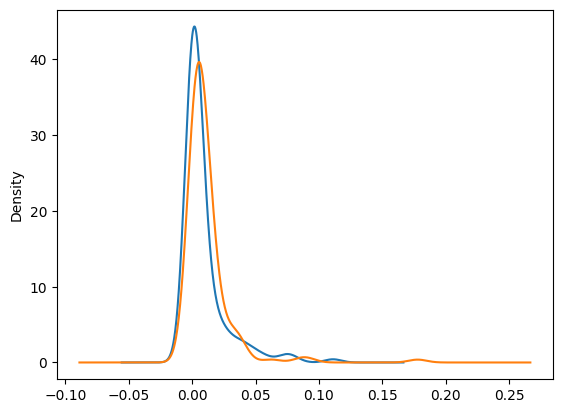

In [47]:
df_groups.groupby(["group"])["freq_subtype"].plot(kind="kde")

In [50]:
ttest_ind(a=df_groups["freq_subtype"].head(mid).values,
          b=df_groups["freq_subtype"].tail(mid).values,
          equal_var=True,alternative='two-sided',nan_policy="omit")

Ttest_indResult(statistic=1.0826647712746793, pvalue=0.27985662813825235)

In [38]:
ttest_ind(a=df_groups["freq_subtype"].head(mid).values,
          b=df_groups["freq_subtype"].tail(mid).values,
          equal_var=False,alternative="greater",nan_policy="omit")

Ttest_indResult(statistic=1.0840405806742357, pvalue=0.13962551233606613)

In [39]:
ttest_ind(a=df_groups["freq_subtype"].head(mid).values,
          b=df_groups["freq_subtype"].tail(mid).values,
          equal_var=False,alternative="less",nan_policy="omit")

Ttest_indResult(statistic=1.0840405806742357, pvalue=0.8603744876639339)

In [40]:
ttest_ind(a=df_groups["results count - subtype AND res"].head(mid).values,
          b=df_groups["results count - subtype AND res"].tail(mid).values,
          equal_var=False,alternative="greater",nan_policy="omit")

Ttest_indResult(statistic=1.8487221156950282, pvalue=0.03317982237032775)

In [41]:
df_groups["freq_subtype"].tail(mid)

name
reflex epilepsy                                                                                      0.009382
dentinogenesis imperfecta type 2                                                                     0.015038
familial clubfoot with or without associated lower limb anomalies                                    0.004788
response to thiazide                                                                                 0.009346
congenital lipoid adrenal hyperplasia due to star deficency                                               NaN
                                                                                                       ...   
7q11.23 microduplication syndrome                                                                    0.000000
trichorhinophalangeal syndrome type i or iii                                                         0.008709
x-linked intellectual disability - hypogammaglobulinemia - progressive neurological deterioration    0.000000
spast